In [15]:
%matplotlib notebook
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
plt.rcParams['figure.figsize'] = [10, 6]

In [3]:
class ShortestPath:
    def __init__(self, K: int, N: int, Graph):
        self.K = K # number of stages in binomial bridge
        assert(K%2 == 0)
        self.N = N # number of steps
        self.sigma2_tilde = 1
        self.G = Graph
        self.theta = nx.get_edge_attributes(self.G, "theta")
        self.mu_sampled = {edge : -0.5 for edge in nx.edges(self.G)}
        self.sigma2_sampled = {edge : 1 for edge in nx.edges(self.G)}
        self.chosen_paths = []

    def plot_binomial_bridge(self):
        pos = {(x,y):(x+y,x-y) for x,y in self.G.nodes()}

        # nodes
        nx.draw_networkx_nodes(self.G, pos, node_size=300)

        # edges
        nx.draw_networkx_edges(self.G, pos, arrows=True)
        SP_nodes = nx.shortest_path(self.G, (0,0), (self.K//2,self.K//2), weight="theta") # Nodes in shortest path
        SP_edges = [(SP_nodes[i], SP_nodes[i+1]) for i in range(self.K)] # Edges in shortest path
        nx.draw_networkx_edges(self.G, pos, edgelist=SP_edges, edge_color='red', arrows=True)

        # node labels
        nx.draw_networkx_labels(self.G, pos, font_size=7)

        # edge weight labels
        weights = nx.get_edge_attributes(self.G, "theta")
        nx.draw_networkx_edge_labels(self.G, pos, weights)

    def sample_travel_times(self, edges):
        return {edge : np.random.lognormal(np.log(self.theta[edge]) - self.sigma2_tilde/2, self.sigma2_tilde) for edge in edges}

    # update sampled parameters
    def update(self, edges, sampled_travel_time):
        for edge in edges:
            self.mu_sampled[edge] = (self.mu_sampled[edge]/self.sigma2_sampled[edge] + (1/self.sigma2_tilde) * (np.log(sampled_travel_time[edge]) + self.sigma2_tilde/2)) / \
                                 (1/self.sigma2_sampled[edge] + 1/self.sigma2_tilde)
            self.sigma2_sampled[edge] = 1 / (1/self.sigma2_sampled[edge] + 1/self.sigma2_tilde)

    def per_period_regret(self):
        regret = np.zeros(len(self.chosen_paths))
        for i in range(len(self.chosen_paths)):
            regret[i] = nx.path_weight(self.G, self.chosen_paths[i], "theta") - nx.shortest_path_length(self.G, (0,0), (self.K//2,self.K//2), weight="theta")
        return regret

    def run_simulation(self):
        pass

    def get_name(self):
        pass

In [4]:
class EpsilonGreedy(ShortestPath):
    def __init__(self, K: int, N: int, Graph, epsilon: float):
        super(EpsilonGreedy, self).__init__(K, N, Graph)
        self.epsilon = epsilon
        self.run_simulation()

    def run_simulation(self):
        for t in range(self.N):
            if np.random.random() < self.epsilon:
                all_paths=[]
                for path in nx.all_simple_paths(self.G, (0,0), (self.K//2,self.K//2)):
                    all_paths.append(path)
                self.chosen_paths.append(all_paths[np.random.randint(len(all_paths))])
            else:
                theta_sampled = {edge : round(np.exp(self.mu_sampled[edge] + self.sigma2_sampled[edge]/2), 3) for edge in self.G.edges()}
                nx.set_edge_attributes(self.G, theta_sampled, "theta_sampled")

                self.chosen_paths.append(nx.shortest_path(self.G, (0,0), (self.K//2,self.K//2), weight="theta_sampled"))

            chosen_path_edges = [(self.chosen_paths[-1][i], self.chosen_paths[-1][i+1]) for i in range(self.K)] # edges in sampled path

            sampled_travel_time = self.sample_travel_times(chosen_path_edges)

            self.update(chosen_path_edges, sampled_travel_time)

    def get_name(self):
        if self.epsilon == 0:
            return 'Greedy'
        else:
            return f'{self.epsilon}-Greedy'

In [5]:
class AnnealingEpsilonGreedy(ShortestPath):
    def __init__(self, K: int, N: int, Graph, m: int):
        super(AnnealingEpsilonGreedy, self).__init__(K, N, Graph)
        self.m = m
        self.run_simulation()

    def run_simulation(self):
        for t in range(self.N):
            if np.random.random() < self.m/(self.m + t):
                all_paths=[]
                for path in nx.all_simple_paths(self.G, (0,0), (self.K//2,self.K//2)):
                    all_paths.append(path)
                self.chosen_paths.append(all_paths[np.random.randint(len(all_paths))])
            else:
                theta_sampled = {edge : round(np.exp(self.mu_sampled[edge] + self.sigma2_sampled[edge]/2), 3) for edge in self.G.edges()}
                nx.set_edge_attributes(self.G, theta_sampled, "theta_sampled")

                self.chosen_paths.append(nx.shortest_path(self.G, (0,0), (self.K//2,self.K//2), weight="theta_sampled"))

            chosen_path_edges = [(self.chosen_paths[-1][i], self.chosen_paths[-1][i+1]) for i in range(self.K)] # edges in sampled path

            sampled_travel_time = self.sample_travel_times(chosen_path_edges)

            self.update(chosen_path_edges, sampled_travel_time)

    def get_name(self):
        return f'{self.m}/({self.m}+t)-Greedy'

In [6]:
class ThompsonSampling(ShortestPath):
    def __init__(self, K: int, N: int, Graph):
        super(ThompsonSampling, self).__init__(K, N, Graph)
        self.run_simulation()

    def run_simulation(self):
        for t in range(self.N):
            theta_sampled = {edge : round(np.random.lognormal(self.mu_sampled[edge], self.sigma2_sampled[edge]), 3) for edge in self.G.edges()}
            nx.set_edge_attributes(self.G, theta_sampled, "theta_sampled")

            self.chosen_paths.append(nx.shortest_path(self.G, (0,0), (self.K//2,self.K//2), weight="theta_sampled"))

            chosen_path_edges = [(self.chosen_paths[-1][i], self.chosen_paths[-1][i+1]) for i in range(self.K)] # edges in sampled path

            sampled_travel_time = self.sample_travel_times(chosen_path_edges)

            self.update(chosen_path_edges, sampled_travel_time)

    def get_name(self):
        return 'Thompson Sampling'

In [22]:
class SimulationCollection:
    def __init__(self, K: int, N: int, num_simulations: int):
        self.K = K #number of possible actions
        self.N = N #number of steps
        self.num_simulations = num_simulations
        self.Graphs = self.create_many_binomial_bridges()
        self.simulations = {}

    # create binomial bridge with K stages
    def create_binomial_bridge(self):
        G = nx.grid_2d_graph(self.K//2 + 1, self.K//2 + 1, create_using=nx.DiGraph)
        #remove edges in wrong direction
        G.remove_edges_from([edge for edge in nx.edges(G) if edge[0][0] > edge[1][0] or edge[0][1] > edge[1][1]])

        mu = {edge : -0.5 for edge in G.edges()}
        sigma2 = {edge : 1 for edge in G.edges()}

        nx.set_edge_attributes(G, mu, "mu")
        nx.set_edge_attributes(G, sigma2, "sigma2")

        theta_dict = {edge : round(np.random.lognormal(mu[edge], sigma2[edge]), 3) for edge in G.edges()}
        nx.set_edge_attributes(G, theta_dict, "theta")

        return G

    def create_many_binomial_bridges(self):
        Graphs = []
        for _ in range(self.num_simulations):
            Graphs.append(self.create_binomial_bridge())
        return Graphs

    def create_epsilon_greedy(self, epsilon):
        self.simulations[f'EG_{epsilon}'] = []
        for i in range(self.num_simulations):
            epsilon_greedy = EpsilonGreedy(self.K, self.N, self.Graphs[i], epsilon)
            self.simulations[f'EG_{epsilon}'].append(epsilon_greedy)
            print(f"Finished epsilon_greedy experiment {i+1} out of {self.num_simulations}", end="\r")
        print(f"Finished simulation of epsilon greedy                                                        ")


    def create_annealing_epsilon_greedy(self, m):
        self.simulations[f'AEG_{m}'] = []
        for i in range(self.num_simulations):
            annealing_epsilon_greedy = AnnealingEpsilonGreedy(self.K, self.N, self.Graphs[i], m)
            self.simulations[f'AEG_{m}'].append(annealing_epsilon_greedy)
            print(f"Finished annealing_epsilon_greedy experiment {i+1} out of {self.num_simulations}", end="\r")
        print(f"Finished simulation of annealing epsilon greedy                                                        ")

    def create_thompson_sampling(self):
        self.simulations['TS'] = []
        for i in range(self.num_simulations):
            thompson_sampling = ThompsonSampling(self.K, self.N, self.Graphs[i])
            self.simulations['TS'].append(thompson_sampling)
            print(f"Finished thompson sampling experiment {i+1} out of {self.num_simulations}", end="\r")
        print(f"Finished simulation of thompson sampling                                                              ")

    def plot_averaged_regrets(self):
        fig, ax = plt.subplots()

        for sim in self.simulations.values():
            avg_regret = np.mean([sim[i].per_period_regret() for i in range(self.num_simulations)], axis=0)
            ax.plot(range(self.N), avg_regret, label=sim[0].get_name())

        ax.legend()
        ax.set_title('average regret over t time periods')
        ax.set_xlabel('time period t')
        ax.set_ylabel(None)

        plt.show()

Red edges are the shortest path from Start=(0,0) to End=(3, 3)


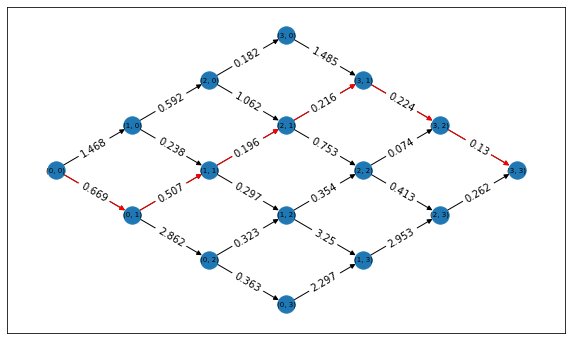

In [17]:
simulations = SimulationCollection(K=6, N=500, num_simulations=1)
G = simulations.Graphs[0]
TS = ThompsonSampling(K=6, N=500, Graph=G)
TS.plot_binomial_bridge()
print(f'Red edges are the shortest path from Start=(0,0) to End=({TS.K//2}, {TS.K//2})')

Finished simulation of epsilon greedy                                                        
Finished simulation of epsilon greedy                                                        
Finished simulation of annealing epsilon greedy                                                        
Finished simulation of thompson sampling                                                              


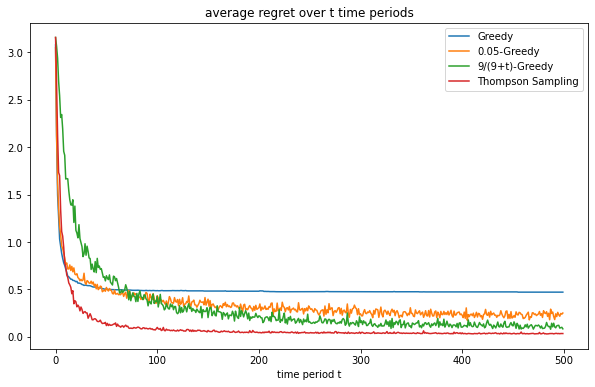

CPU times: total: 12min 15s
Wall time: 12min 15s


In [25]:
%%time

simulations = SimulationCollection(K=10, N=500, num_simulations=1000)
simulations.create_epsilon_greedy(0)
simulations.create_epsilon_greedy(0.05)
simulations.create_annealing_epsilon_greedy(9)
simulations.create_thompson_sampling()

simulations.plot_averaged_regrets()